# Overview

This is a CNN project for a dataset consisting of labeled chest x-ray images.  There are over 200k x-rays in the dataset, each labeled with 14 findings.  The dataset in its raw form is both multi-label and multi-class in that each x-ray can have more than one label, and each of these labels can be one of 4 values (non mentuned, negative, uncertain and positive).

This project will reduce this dataset to about 137k images with 12 binary labels making this project just a multi-label CNN problem.

The dataset comes from the Stanford Machine Learning group and can be accessed via this link:
https://stanfordmlgroup.github.io/competitions/chexpert/

# Purpose

The purpose of this project is to build a framework that will easily allow repeatable runs of the dataset with variable parameters, images counts, models, etc.  Though it is always desired to produce the best possible accuracy, recall and precision in our predictions, the main goal of this project is to build the framework to more easily allow finetuning of model runs and not specifically finding the best configuration.


# Goals

### Build a Framework for better Understanding

The primary goal of this project is to gain a deeper understanding of CNN and PyTorch.  There are already a lot of frameworks out there that do a lot more than what is built into this project, Keras and TensorBoard are some good examples.

But it is very difficult to get a good understanding of what is happening behind the scenes if the work is already done for you.  So in this project, preference is given to manual coding over pre-built packages.  

The coding mistakes and wrong assumptions made in this journey are invaluable.  In fact, these missteps are the key to better understanding.  Things like:
- Why can't I build the ROC curve from just my actual and predicted labels?
- Why is my accuracy over 90% when all my predictions are negative?
- Why can't I use pre-trained models with my grayscale images?
- How do I get my model's output to match my loss function?

There is no intention of making a framework that is better than ones already available.  Chances are for future CNN projects, I will use a lot more pre-built packages.  But the hope is the understanding gained with this project will allow me to leverage features and parameters in these packages much more accurately and efficiently.

### Code Reuse / Repeatable Model Runs

Jupyter Notebooks are a great way of combining code, visualizations and descriptive text in a single location.  But using notebooks for repeatable runs is not the most efficient approach.  You can copy/paste code or entire notebooks, but if you need to make a change, you have to change every notebook.  

Building Python modules to house the repeatable code is a much better approach and the route taken with this project.

Notebooks are used for specific runs, i.e. DenseNet vs. ResNet, Learning Rate 1e-4 vs. Learning Rate 1e-6.  But since most of the code is in modules, these notebooks (other than a couple of bootstrap blocks) contain only the model and training loop configurations.


# Dataset

The raw dataset comes as a set of images along with a csv index file.  There is one row in the csv file for each x-ray.
There are both train and validation dataset with 223,415 and 234 images respectively.  Since the validation set was so small, only the train dataset was used.  These 223,415 images were randomly split into train and val during the model runs.

The csv contains some tabular features such as sex and age, aspectes of the image such as orientation and view, and a path for the image file.

The csv also contains the 14 labels:
- Enlarged_Cardiomediastinum
- Cardiomegaly
- Lung_Opacity
- Lung_Lesion
- Edema
- Consolidation
- Pneumonia
- Atelectasis
- Pneumothorax
- Pleural_Effusion
- Pleural_Other
- Fracture
- No Finding
- Support Devices (i.e. pacemakers)

Any image can have any number of labels making this a multi-label dataset.  i.e. An x-ray can show both Pleural Effusion and Cardiomegaly.

Also, each of these labels can have one of 4 values:
- Not Mentioned = Null
- Negative = -1
- Uncertain = 0
- Positive = 1

How the x-ray was taken is stored in 2 columns, "Frontal/Lateral" and "AP/PA".  Lateral x-rays are taken from the patient's side.  AP/PA stands for Anterior and Posterior.  AP means the x-rays entered the patient's from and exited out of the patient's back and PA is the opposite.  

From the image path, we can parse out a PatientID and StudyID.  A study is a set of x-rays taken at the same time.  A study can have just a single frontal x-ray, a single lateral x-ray or have both a frontal and lateral set of x-rays.
Patients who only had one set of x-rays will have only a StudyID of 1.  Patients with multiple studies will have StudyIDs 1,2,3,4,....  The max number of studies for a single patient in this dataset was 72.

# CheXpert User Agreement

The images in this dataset cannot be made publically available.  Because of this, the images are not included in this project.  But you can obtain the dataset yourself and run this code.  You may need to adjust the working directories in the top bootstrap code block at the start of every notebook.

*Note:  See Hierarchical Path below for special directory structure*

# EDA

In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

Current Working Dir:  C:\git\Springboard-Public\Capstone Project 2
Root Path:  C:/git/Springboard-Public/Capstone Project 2/


In [2]:
import sys
import os, os.path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from modules.lib.ChextXRayImages import CleanMetaData
from modules.lib.TrainingLoop import *
from modules.lib.Metrics import *
from modules.lib.StandardTraining import *

%matplotlib inline

# Data Cleansing

To see the process of data cleaning, please go to the supporing notebook: 
<a href="notebooks/Support%20Notebooks%20for%20Modules/EDA.ipynb" >EDA Support Notebook</a>

To see the module, please go to:
<a href="modules/lib/ChextXRayImages.py" >ChextXRayImages</a>

### Frontal only
To reduce the complexity of learning and to reduce the overall number of images, only frontal views were included.  

### Multiple Studies
To prevent a patients with serial studies biasing the results, only the first 4 studies were included in the clean dataset. 

These 2 filters reduced the image count from 223,415 to 131,748.

    df_reduced = df[
                (df.View == 'Frontal') & # Don't show x-rays from the side
                (df.StudyID < 5) & # Don't include more than 4 studies for a single patient
                ((df.Orientation == 'AP') | (df.Orientation == 'PA')) # Don't show Left or Right Lateral
                ]

### 12 Targets
Two targets were removed from the original 14:
- No Finding
- Support Devices

The first was removed for the same reason we do with one-hot encoding.
Support Devices (i.e. Pacemakers, LVAD, etc.) was removed since these findings could be considered more of a feature than a diagnosis.

### Binary Labels
To reduce the complexity of combining multi-label and multi-class classifications, the labels were converted into Boolean values.

- Not Mentioned = 0
- Negative = 0
- Uncertain = 0
- Positive = 1

# CleanMetaData

In [3]:
metaData = CleanMetaData()
df_clean= metaData.getCleanDF()
display(df_clean)

,PatientID,StudyID,Age,Sex_Male,Sex_Unknown,Orientation_PA,Support Devices,Image_Path,Hierarchical_Path,Enlarged_Cardiomediastinum,...,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
ImageID,,,,,,,,,,,,,,,,,,,,,
0,1,1,68,0,0,0,1.0,data/raw/train/patient00001/study1/view1_front...,data/d0/d1/i0.jpg,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,87,0,0,0,0.0,data/raw/train/patient00002/study2/view1_front...,data/d1/d2/i1.jpg,0,...,1,0,0,0,0,0,0,0,0,1
2,2,1,83,0,0,0,0.0,data/raw/train/patient00002/study1/view1_front...,data/d2/d2/i2.jpg,0,...,1,0,0,0,0,0,0,0,0,1
4,3,1,41,1,0,0,0.0,data/raw/train/patient00003/study1/view1_front...,data/d4/d3/i4.jpg,0,...,0,0,1,0,0,0,0,0,0,0
5,4,1,20,0,0,1,0.0,data/raw/train/patient00004/study1/view1_front...,data/d5/d4/i5.jpg,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,64537,2,59,1,0,0,0.0,data/raw/train/patient64537/study2/view1_front...,data/d9/d37/i223409.jpg,0,...,0,0,0,0,0,0,0,1,0,0
223410,64537,1,59,1,0,0,0.0,data/raw/train/patient64537/study1/view1_front...,data/d10/d37/i223410.jpg,0,...,0,0,0,0,0,0,0,0,0,0
223411,64538,1,0,0,0,0,0.0,data/raw/train/patient64538/study1/view1_front...,data/d11/d38/i223411.jpg,0,...,0,0,0,0,0,0,0,0,0,0


# Intrinsic Leaks
Though there is nothing we can do about this, there are intrinsic leaks in the images that we should be aware of.

In-patients are much more likely to have positive findings then out-patients, especially out-patient routine screening x-rays. In-patient x-rays oftentimes can have leaks in the images.  ECG leads, IVs and gown snaps are often present.  Higher acuity patients will oftentimes have their x-rays taken in bed with AP orientation.  PA is preferred since it does not tend to exaggerate the cardiac silhouette.  Also, it might be harder to properly align very sick patients.  All of these can leak features more common in positive diagnoses.  

### X-Ray with ECG Leads indicating an in-patient

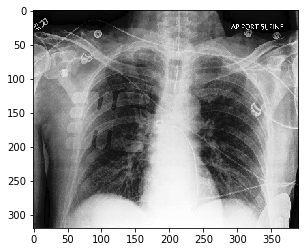

In [4]:
img = metaData.displayImage(123)
imgplot = plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

# Target Interdependence
Though each of the 12 labels can be found independently of each other, it is very common to have findings that correlate with other findings.  For example, it would be more common to find atelectasis in patients with pneumonia or pleural effusions.  Rib fractures may make it painful to ambulate potentially leading to other lung diseases such as atelectasis or pneumonia.

Patients with high comorbidities may have several of these findings.  Diagnoses like Cardiomeglia tend to not be transient and can persist for years.  These longer term diseases may or may not correlate to other pathologies.

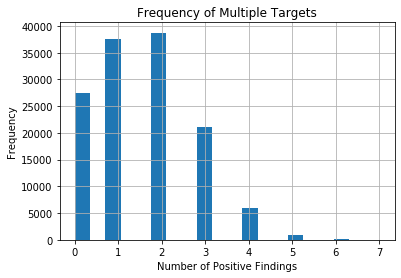

In [5]:
ax = df_clean.iloc[:, -12:-1].sum(axis=1).hist(bins=20) 
ax.set_title('Frequency of Multiple Targets')
ax.set_xlabel('Number of Positive Findings')
ax.set_ylabel('Frequency')
plt.show()

# Imbalance

One of the biggest chalanges is the imbalance of the 12 targets.  

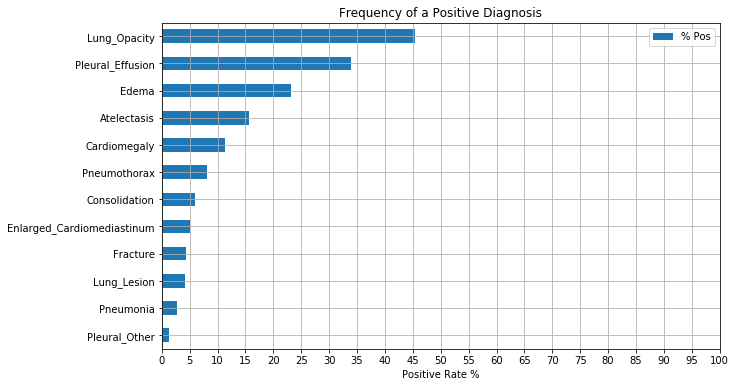

In [6]:
ax =pd.DataFrame(df_clean.iloc[:, -12:].sum() / len(df_clean) * 100, 
             columns=['% Pos']).sort_values('% Pos').plot.barh(figsize=(10,6))
ax.set_title("Frequency of a Positive Diagnosis")
ax.set_xlabel("Positive Rate %")
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 5))
ax.grid()

# Environments

This project is intended to run both locally with GPU and on Google CoLab.  Locally (GEFORCE RTX 2080 - 8GB), most models run very well, but might need to adjust the batch size down for some. The same notebooks can also run on Google CoLab without any changes.  The bootstrap code block at the top of the notebooks determines the working directory on both environments and sets the PyTorch device to cuda. 

Most if not all of the notebooks in this project were completed locally.  Though CoLab has the advantage from a computational power perspective, it is very slow accessing the image files.

# Hierarchical Directory

To see how to implement the hierarchical path, see: 
<a href="notebooks/Support%20Notebooks%20for%20Modules/HierarchicalPath.ipynb" >Hierarchical Path Notebook</a>

In Google CoLab, the images need to be accessible.  Since the dataset is not public and there is no API to retrieve the images, you need to mount a drive in order for CoLab to get access to these images.  In the CoLab environment, the images are stored on Google Drive.  There are plenty of posts on how to mount a drive in this way.

But the directory structure on Google Drive is not the same as your local file system.  Since Google Drive is primarily a web based application, it cannot navigate directly to a file via a path.  So every time you give it a path, a call must be made to obtain an ID for the folder and or path before it can access it.  That means that every image read during the training loop must do a lookup of the item ID first.

With over 200k files, the training loop would have to find the ID out of 200,000 IDs.  But it has to do this for every image, so the number of lookups in a single epoch would be 200k X 200k which is over 40 billion lookups.

In fact, just uploading the images to Google Drive was extremely slow.  After several days of upload, the process was still not done.  A silent timeout error was occuring most of the time so many of the uploaded images didn't get to the drive.  See top of HierarchicalPath.ipynb (link above).

After a fair amount of research, the approach taken to resolve this was to copy the files into a hierarchical folder structure where no more than 50 items existed in any one folder.  To get the proper ID, there are only 3 ID lookups, each with only 50 items.  So instead of 200k lookup, we only needed to do 150.  

Though this did resolve the timeout issue, the training loops were still much slower than running locally.  So all models were run locally as long as there was enough memory to support it.

*Note:  The hierarchical directories greatly helped the upload process!*

# Project Directory Structure


## data

###    Raw
-   Origional files downloaded from CheXpert
-   Holds metadata csv files from CheXpert
-   Holds download x-ray images

###    intermediate
-   Holds Clean DF

###    d0 through d49
-   Holds same x-ray images, but in a hierarchical directory structure for CoLab

## modules

#### lib
-   ChextXRayImages – DataFrame/DataSet/DataLoaders
* 
-   TrainingLoop
-   StandardTraining
-   Metrics

#### models
-   CustomPneumonia
-   DenseNet
-   ResNet

## notebooks
-   Educational - Two notebooks exploring PyTorch
    *     Pytorch Linear Regression from Scratch
    *     Pytorch Automatic Differentiation
-   Kaggle Pneumonia - Very early work with CNN on Kaggle Pneumonia chest x-rays
-   Support Notebooks for Modules - The workspace used to help build the modules
-   ModelLoop - Notebooks that run combinations of different modes and/or parameters with a reduced dataset
-   ModelRuns - Notebooks that train a single model and parameters



# Models Used
### Custom
### ResNet
### Dropout
-   Pre-Trained
-   DenseNet
# Training Features
### Criterion
### BCEWiogitsLoss
-   pos_weight
-   Reduction
### Optimizer
-   Adam
-   L2 Regularization
### Image Augmentations
-   Affine
-   Translation
-   Shear
-   Brightness
-   Contract
### Oversampling
-   Min observation count
### Training Targets
# Metrics
### Epoch (Itemized)
-   Recall
-   Precision
-   F1
-   ROC AUC
-   Avg Precision
### Training Completion
-   Accuracy
-   All Labels
-   Hamming Loss
-   Combined Recall/Precision
-   ROC / Precision-Recall Curves
### Epoch Progression
-   Accuracy
-   Recall
-   Precision
-   F1
-   ROC AUC
-   Avg Precision
-   Persistence
Combination Tried
A
B
C
D
Results
Educational Notebooks
Todo


In [7]:
save_name = 'ResNet34_Oversample_L2_Sum_PosWeight_5_Targets'
path= f'notebooks/saved/{save_name}/'
StandardTraining.displayRunParameters(path)
metrics = StandardTraining.loadMetrics(path) 

Network Name:  ResNet_GrayScale
Nework Arguments:  layers:34,drop_out_precent:0.5,out_channels:5


,Paramter,Value
0,number_images,0
1,batch_size,64
2,learning_rate,1e-05
3,num_epochs,4
4,epoch_args,standard
5,use_positivity_weights,True
6,image_width,320
7,image_height,320
8,affineDegrees,5
9,translatePrecent,0.05


Targets:  Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion


In [8]:
save_name = 'DenseNet_Oversample_L2_Sum_PosWeight_5_Targets'
path= f'notebooks/saved/{save_name}/'
StandardTraining.displayRunParameters(path)
metrics = StandardTraining.loadMetrics(path) 

Network Name:  ResNet_GrayScale
Nework Arguments:  nr_classes:5


,Paramter,Value
0,number_images,250
1,batch_size,16
2,learning_rate,1e-05
3,num_epochs,6
4,epoch_args,standard
5,use_positivity_weights,True
6,image_width,224
7,image_height,224
8,affineDegrees,5
9,translatePrecent,0.05


Targets:  Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion


In [9]:
# metrics.displayMetrics()   

In [10]:
# metrics.displayEpochProgression()